In [1]:
import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                           

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize              

import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    
from tqdm import tqdm_notebook

import warnings                                 
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Извлечение признаков (Feature exctraction)
Итак, для модели нужны признаки, а у нас есть только одномерный временной ряд, что можно придумать?

Конечно же, лаги временного ряда
Статистики по окнам:
Минимальное/максимальное значение ряда в окне
Среднеё/медианное значение по окну
Дисперсия по окну
и т.д.
Признаки из самой даты и времени:
Минута часа, час дня, день недели, месяц года и т.д.
Является ли день праздником/выходным/специфическим днём
Кодирование средним
Прогнозы других моделей (но тут в скорости можно потерять)
Пройдемся по некоторым из способов и посмотрим, что мы можем вытащить из нашего временного ряд### а с рекламой

Лаги

 временного ряда
Сдвигая ряд на 
 шагов мы получаем столбец-признак, в котором текущему значению ряда в момент 
 будет соответствовать его значение в момент времени 
. Таким образом, если сделать отступ в 1 шаг, то модель, обученная на таком признаке, будет способна давать предсказание на 1 шаг вперед, зная текущее состояние ряда. Увеличивая сдвиг, например, до 6 лага позволит модели делать предсказания на 6 шагов вперёд, однако опираться она будет на данные, которые видела 6 временных периодов назад и если за это время что-то кардинально поменялось, модель сразу не уловит изменений и выдаст прогноз с большой ошибкой. Поэтому при выборе начального лага приходиться балансировать между желанием получить предсказания на бОльшее число периодов вперёд и приемлимым качеством предсказания

In [3]:
#Будем использовать данные по курсу пары BTC-USD. Источник данных https://www.kaggle.com/datasets/jessevent/all-crypto-currencies
btc_df = pd.read_csv('data/BTC-USD.csv', index_col=['timestamp'], parse_dates=['timestamp'])

In [4]:
#обзор таблицы
btc_df.head(10)

,adjclose,open,high,volume,low,close
timestamp,,,,,,
2014-09-17,457.334015,465.864014,468.174011,21056800,452.421997,457.334015
2014-09-18,424.440002,456.859985,456.859985,34483200,413.104004,424.440002
2014-09-19,394.795990,424.102997,427.834991,37919700,384.532013,394.795990
2014-09-20,408.903992,394.673004,423.295990,36863600,389.882996,408.903992
2014-09-21,398.821014,408.084991,412.425995,26580100,393.181000,398.821014
2014-09-22,402.152008,399.100006,406.915985,24127600,397.130005,402.152008
2014-09-23,435.790985,402.092010,441.557007,45099500,396.196991,435.790985
2014-09-24,423.204987,435.751007,436.112000,30627700,421.131989,423.204987
2014-09-25,411.574005,423.156006,423.519989,26814400,409.467987,411.574005


In [5]:
# Удалим все столбцы, кроме "close"
btc_df.drop(['adjclose', 'open', 'high', 'volume', 'low'], axis= 1 , inplace= True)

In [6]:
# возьмем только первые 500 строк
data = btc_df.iloc[0:500].copy()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2014-09-17 to 2016-01-29
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   500 non-null    float64
dtypes: float64(1)
memory usage: 7.8 KB


In [8]:
# создадим новые признаки ЛАГИ с 6 по 25
for i in range(6, 25):
    data[f"lag_{i}"] = data['close'].shift(i)

In [9]:
data.head(20)

,close,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
timestamp,,,,,,,,,,,,,,,,,,,,
2014-09-17,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-18,424.440002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-19,394.795990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-20,408.903992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-21,398.821014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-22,402.152008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-23,435.790985,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-24,423.204987,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-09-25,411.574005,394.795990,424.440002,457.334015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
# для рассчета ошибки на кросс-валидации будем бить ряд на 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [11]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
        Производит разделеие на тренировочные-обучающие данные с учетом структуры временного ряда
    """
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(X)*(1-test_size))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [12]:
y = data.dropna().close
X = data.dropna().drop(['close'], axis=1)
# print(X)
# print(y)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [13]:
# Создаем модель регресси и обучаем модель на разделенных данных
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [14]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

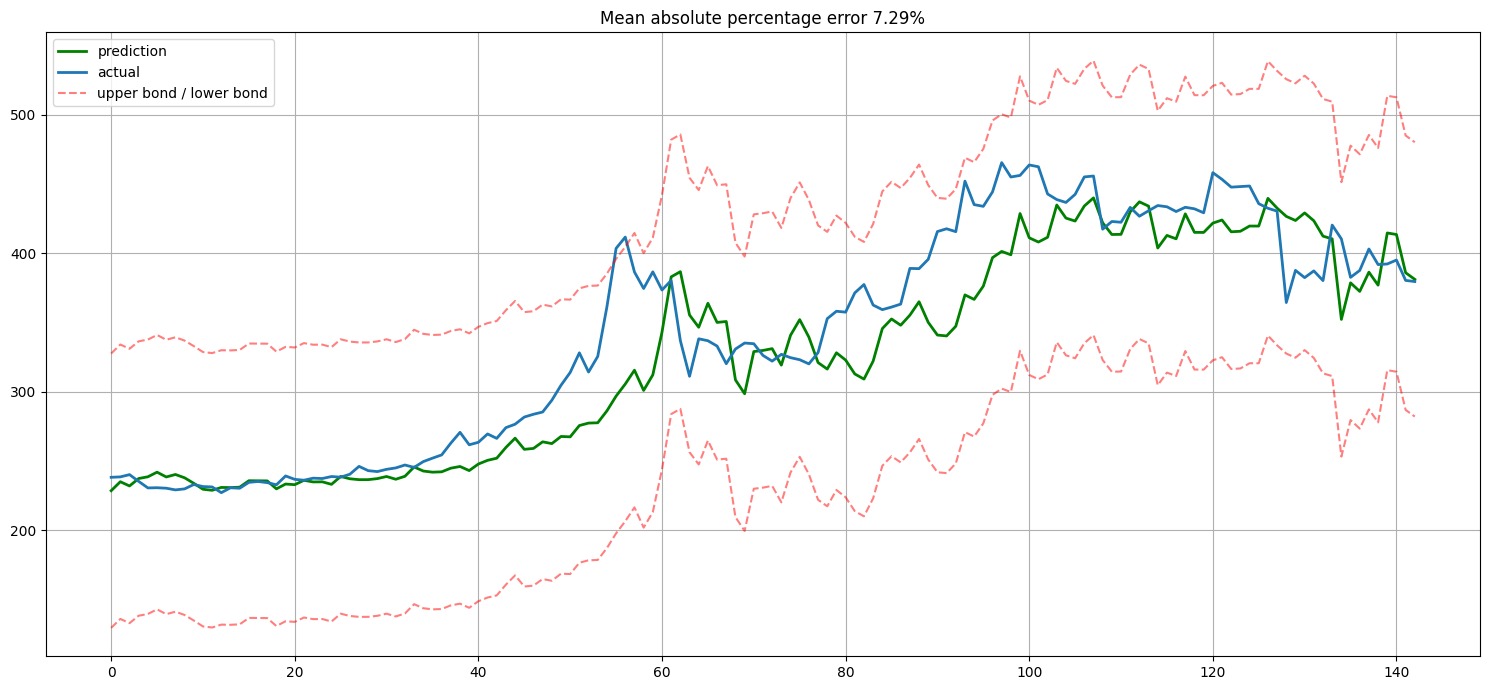

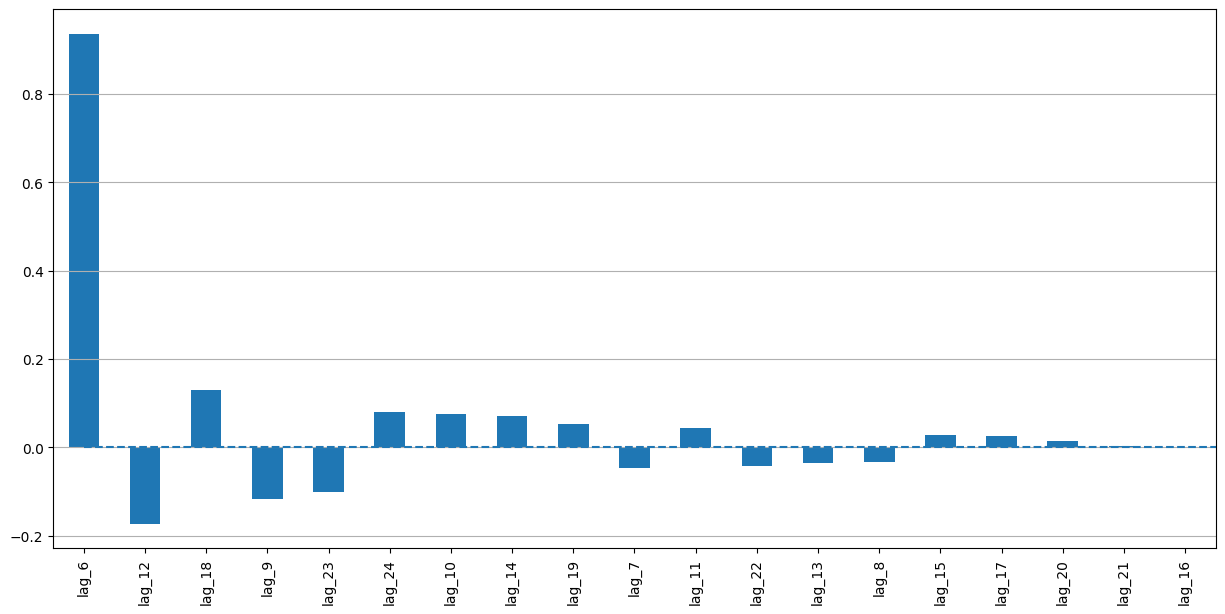

In [15]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

In [16]:
data.index = pd.to_datetime(data.index)
#Создадим новые признаки "weekday" и "шы_weekend"
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,close,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,weekday,is_weekend
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-25,391.726013,380.148987,387.167999,382.299011,387.536011,364.330994,430.306000,432.371002,435.690002,448.428009,...,453.230011,458.048004,429.105011,431.959991,433.091003,430.010986,433.437988,434.334015,0,0
2016-01-26,392.153015,420.230011,380.148987,387.167999,382.299011,387.536011,364.330994,430.306000,432.371002,435.690002,...,447.610992,453.230011,458.048004,429.105011,431.959991,433.091003,430.010986,433.437988,1,0
2016-01-27,394.971985,410.261993,420.230011,380.148987,387.167999,382.299011,387.536011,364.330994,430.306000,432.371002,...,447.990997,447.610992,453.230011,458.048004,429.105011,431.959991,433.091003,430.010986,2,0
2016-01-28,380.289001,382.492004,410.261993,420.230011,380.148987,387.167999,382.299011,387.536011,364.330994,430.306000,...,448.428009,447.990997,447.610992,453.230011,458.048004,429.105011,431.959991,433.091003,3,0
2016-01-29,379.473999,387.490997,382.492004,410.261993,420.230011,380.148987,387.167999,382.299011,387.536011,364.330994,...,435.690002,448.428009,447.990997,447.610992,453.230011,458.048004,429.105011,431.959991,4,0


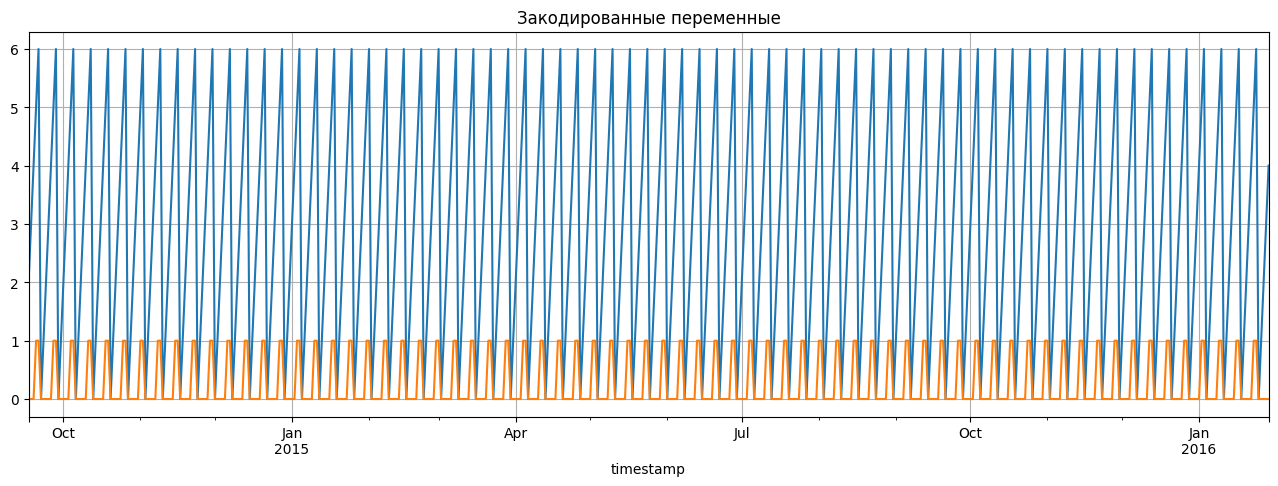

In [17]:
# Построим графики новых признаков
plt.figure(figsize=(16, 5))
plt.title("Закодированные переменные")
#data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

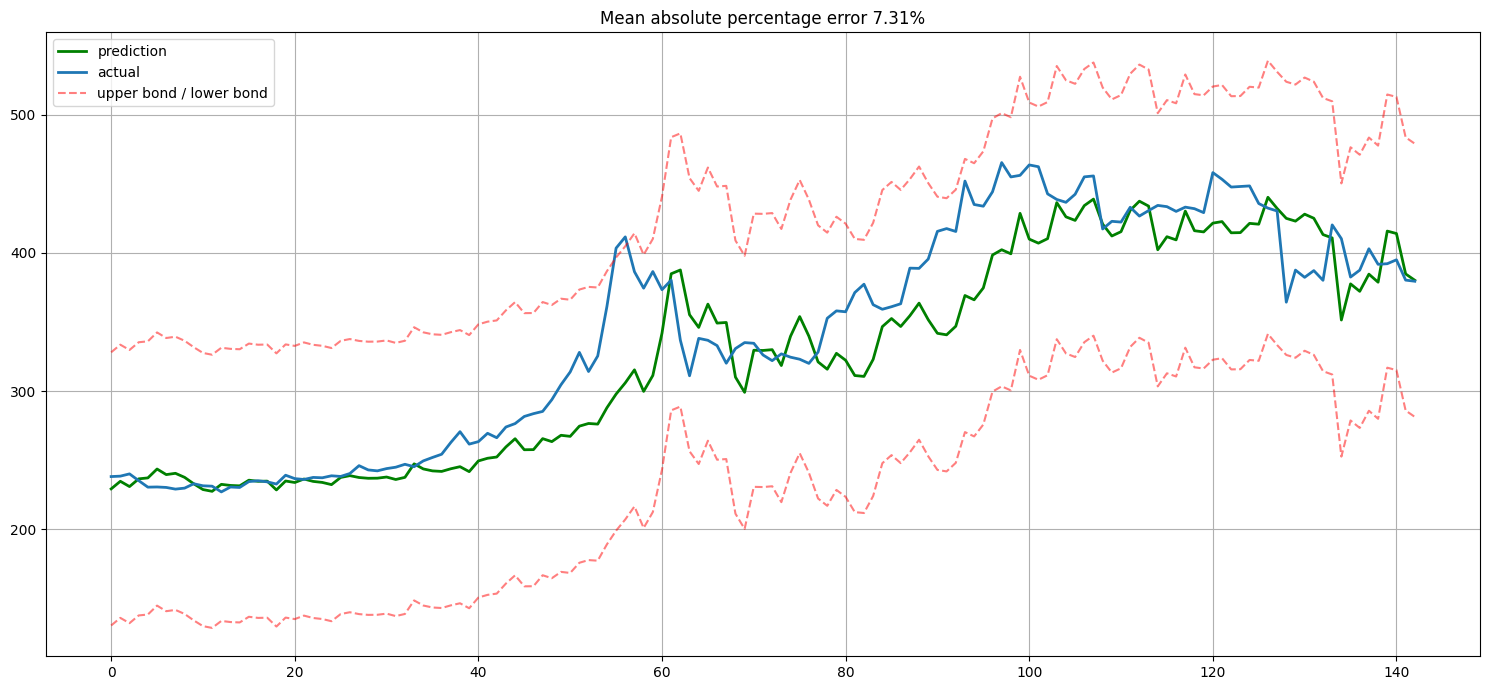

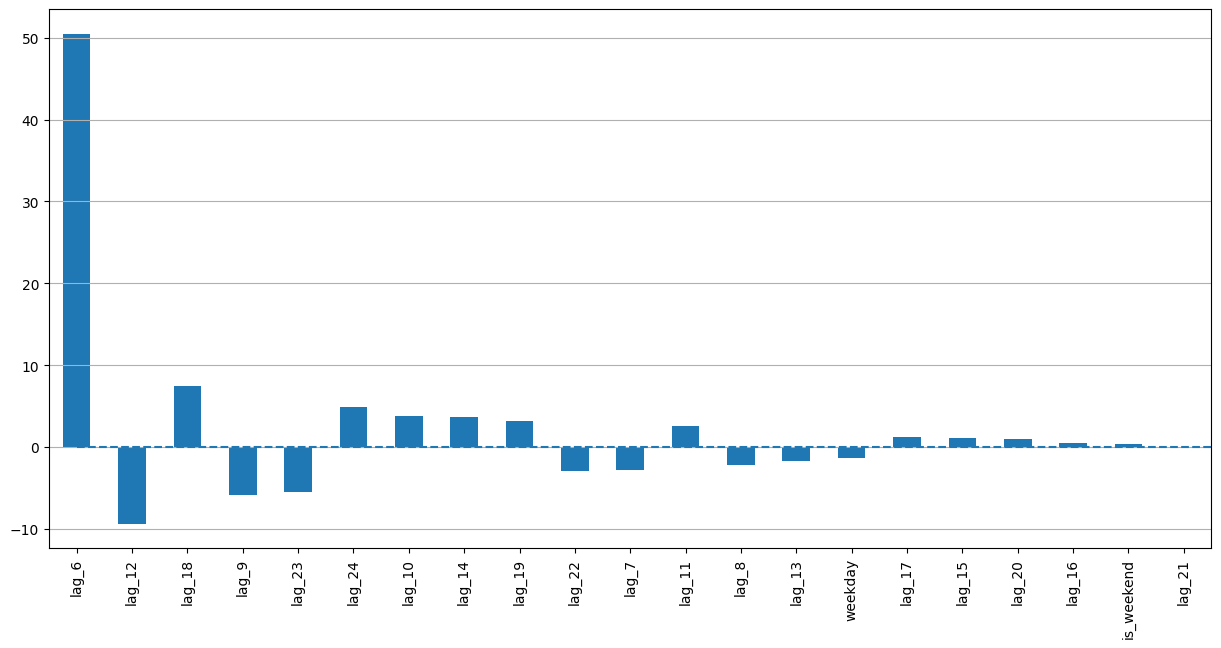

In [19]:
y = data.dropna().close
X = data.dropna().drop(['close'], axis=1)

# разбиваем датасет на тренировочную и тестовую часть, отложим 30% данных
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
# Строим кривые модели
plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

## Кодирование средним

Иногда в качестве признака добавлять среднее значение целевой переменной. В нашем случае каждый день недели или час дня можно закодировать сооветствующим средним числом просмотров рекламы/траты инровой валюты, пришедшиеся на этот день недели или этот час. При этом важно следить за тем, чтобы расчет среднего значения производился только в рамках тренировочного датасета (или в рамках текущего наблюдаемого фолда при кросс-валидации), иначе можно ненароком привнести в модель информацию о будущем.

In [20]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [21]:
average_hour = code_mean(data, 'weekday', "close")

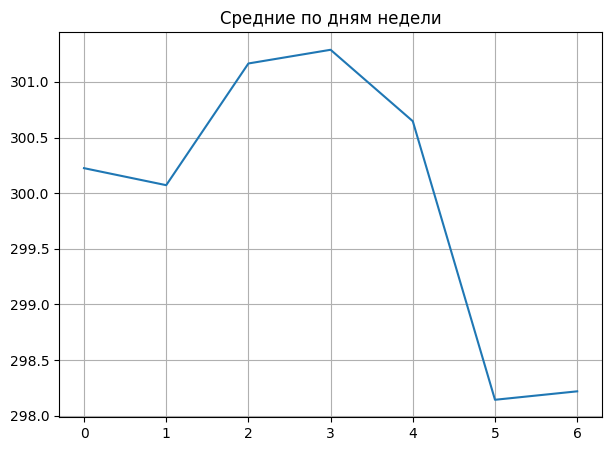

In [22]:
plt.figure(figsize=(7, 5))
plt.title("Средние по дням недели")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

In [23]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries
            Датафрейм с временным рядом

        lag_start: int
            initial step back in time to slice target variable
            начальные лаг в прошлое для разделения целевой переменной
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today
            пример: lag_end = 1 означает, что модель будет будет учитывать "вчерашние" значения что бы предсказать сегодня
            
        lag_end: int
            final step back in time to slice target variable
            последний шаг назад по времени для разделения целевой переменной
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today
            пример: lag_end = 4 означает, что модель будет будут смотреть до 4х дней "назад" во времени что бы предсказать сегодня

        test_size: float
            size of the test dataset after train/test split as percentage of dataset
            размер проверочного датасэта после разделени трениров./проверочные в процентах

        target_encoding: boolean
            if True - add target averages to the dataset
            если True - добавляет признак по среднему в датасэт
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    data.index = pd.to_datetime(data.index)
    #data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        #data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # выкидываем закодированные средними признаки 
        data.drop(["weekday"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

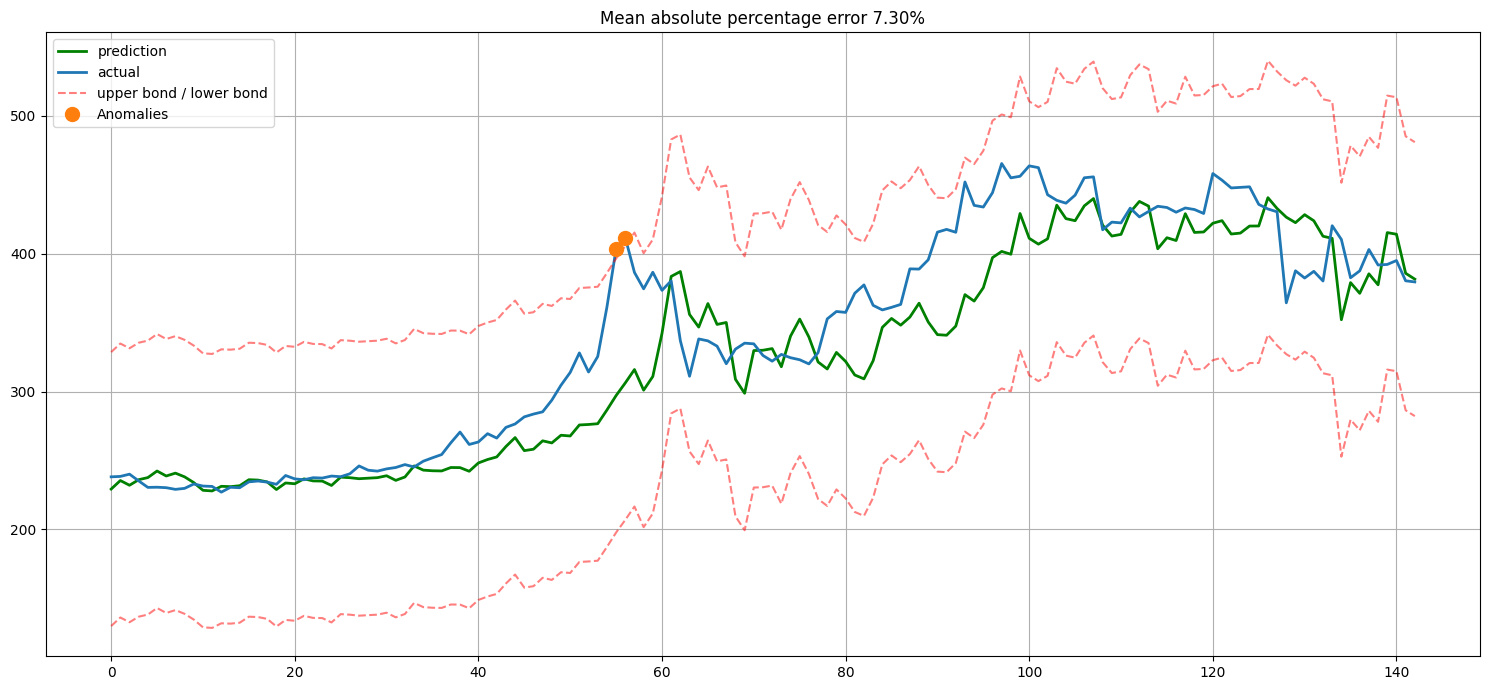

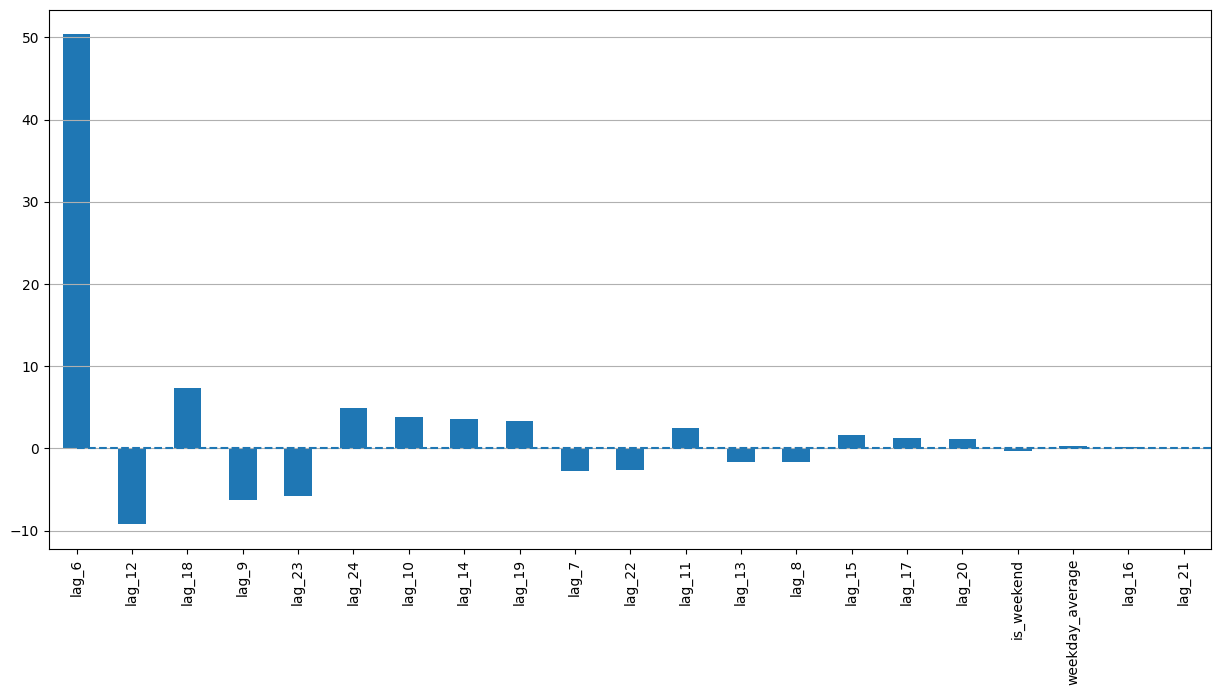

In [34]:
X_train, X_test, y_train, y_test =\
prepareData(btc_df.close.iloc[:500], lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# учим регрессию
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

# Регуляризация и отбор признаков

Используем модели LassoCV и RidgeCV на тех же разделенных данных

In [25]:
from sklearn.linear_model import LassoCV, RidgeCV

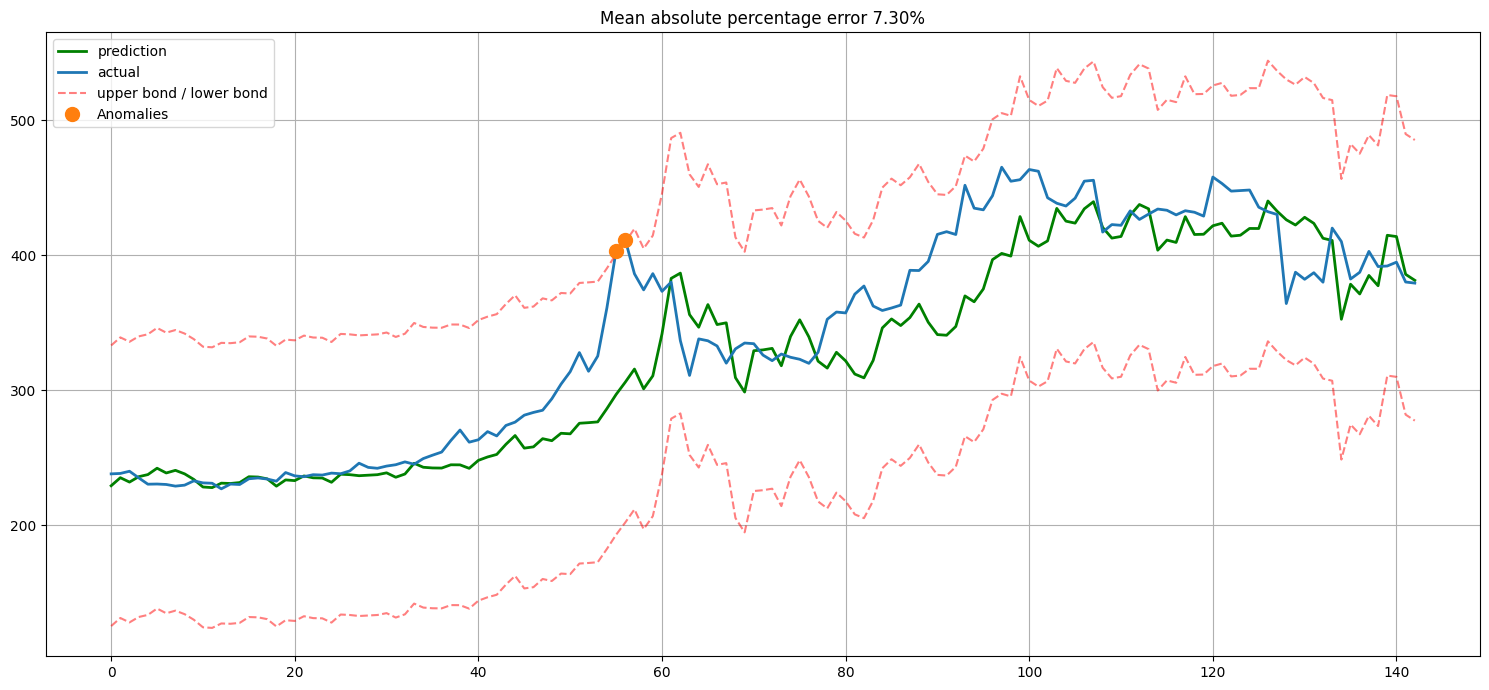

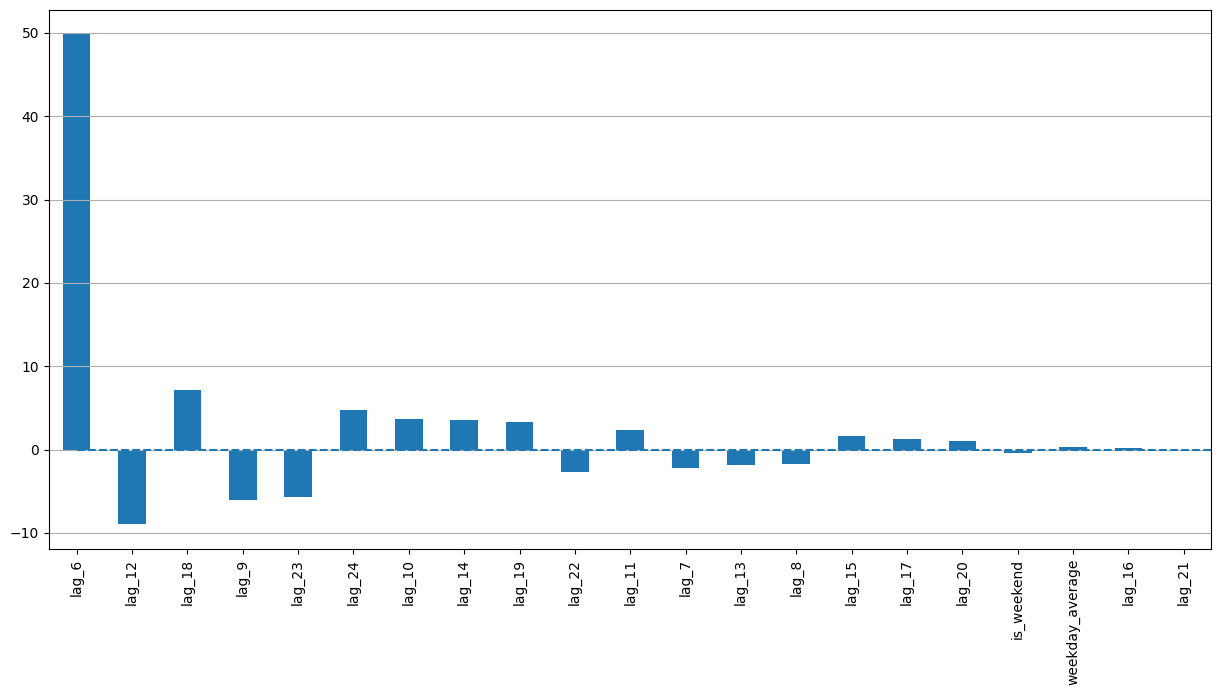

In [35]:
ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

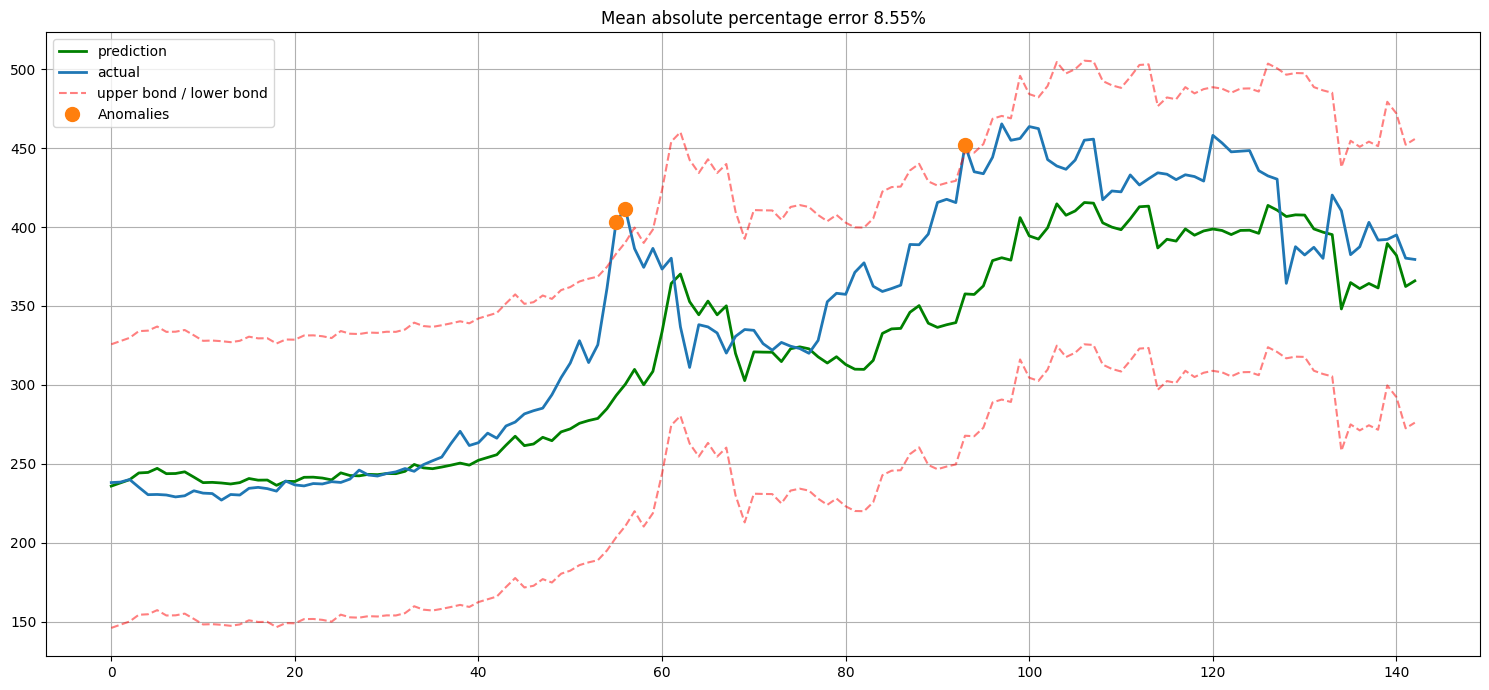

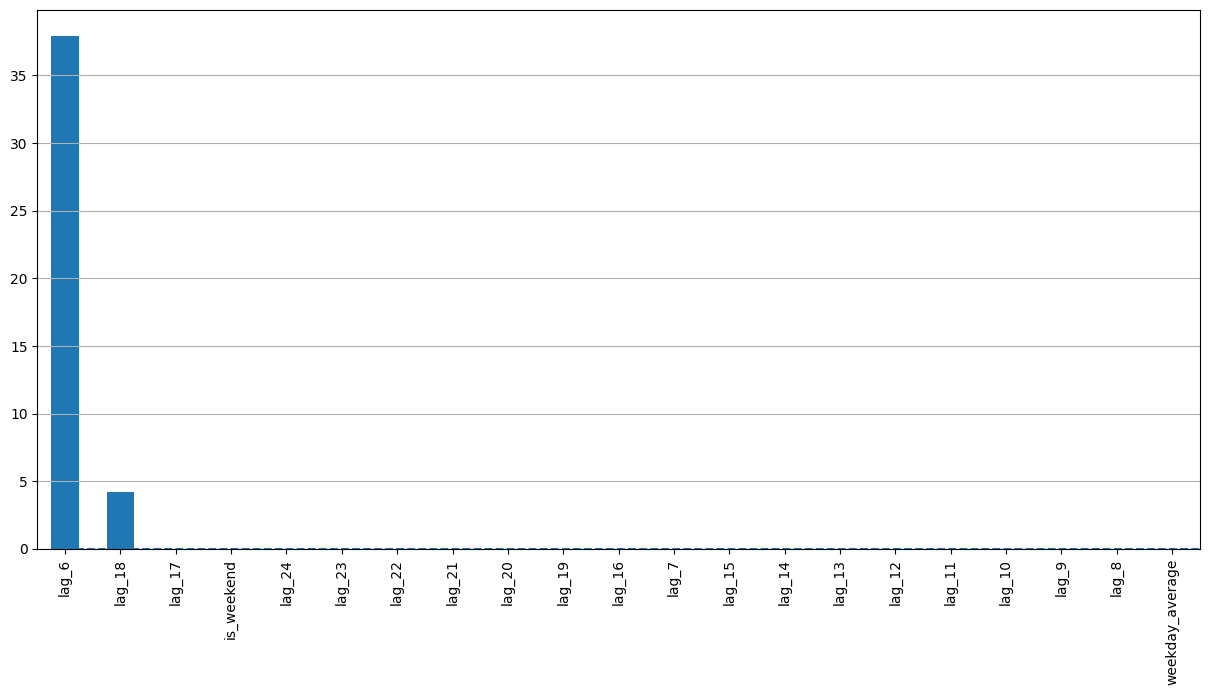

In [36]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)